In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras import callbacks, regularizers
from sklearn.metrics import classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.metrics import Precision, Recall
import tensorflow.keras.backend as K

In [3]:
# Load datasets
df = pd.read_csv('diabetic_data.csv')

# Show shapes
print("Main dataset shape:", df.shape)

# Preview the data
print("\nMain dataset preview:")
df.head()

Main dataset shape: (101766, 50)

Main dataset preview:


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
# Check for nulls or unknowns
print("\nMissing values:")
print(df.isnull().sum().sort_values(ascending=False).head(10))

print("\nUnique values in target column:")
print(df['readmitted'].value_counts())


Missing values:
max_glu_serum    96420
A1Cresult        84748
encounter_id         0
nateglinide          0
glimepiride          0
acetohexamide        0
glipizide            0
glyburide            0
tolbutamide          0
pioglitazone         0
dtype: int64

Unique values in target column:
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64


In [5]:
# Load the full CSV as raw text
raw_mapping = pd.read_csv('IDS_mapping.csv', header=None)

# Split into 3 dataframes by row ranges (0-indexed)
df1 = raw_mapping.iloc[0:9].dropna(how='all')
df2 = raw_mapping.iloc[10:42].dropna(how='all')
df3 = raw_mapping.iloc[42:69].dropna(how='all')

# Print previews
print("== DF1 ==")
df1

== DF1 ==


,0,1
0,admission_type_id,description
1,1,Emergency
2,2,Urgent
3,3,Elective
4,4,Newborn
5,5,Not Available
6,6,NaN
7,7,Trauma Center
8,8,Not Mapped


In [6]:
print("\n== DF2 ==")
df2


== DF2 ==


,0,1
10,discharge_disposition_id,description
11,1,Discharged to home
12,2,Discharged/transferred to another short term h...
13,3,Discharged/transferred to SNF
14,4,Discharged/transferred to ICF
15,5,Discharged/transferred to another type of inpa...
16,6,Discharged/transferred to home with home healt...
17,7,Left AMA
18,8,Discharged/transferred to home under care of H...
19,9,Admitted as an inpatient to this hospital


In [7]:
print("\n== DF3 ==")
df3


== DF3 ==


,0,1
42,admission_source_id,description
43,1,Physician Referral
44,2,Clinic Referral
45,3,HMO Referral
46,4,Transfer from a hospital
47,5,Transfer from a Skilled Nursing Facility (SNF)
48,6,Transfer from another health care facility
49,7,Emergency Room
50,8,Court/Law Enforcement
51,9,Not Available


In [8]:
df['target'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
df.drop(['encounter_id', 'patient_nbr', 'readmitted'], axis=1, inplace=True)
df.replace('?', pd.NA, inplace=True)

df

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,target
0,Caucasian,Female,[0-10),<NA>,6,25,1,1,<NA>,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,[10-20),<NA>,1,1,7,3,<NA>,<NA>,...,No,Up,No,No,No,No,No,Ch,Yes,0
2,AfricanAmerican,Female,[20-30),<NA>,1,1,7,2,<NA>,<NA>,...,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,[30-40),<NA>,1,1,7,2,<NA>,<NA>,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,[40-50),<NA>,1,1,7,1,<NA>,<NA>,...,No,Steady,No,No,No,No,No,Ch,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,[70-80),<NA>,1,3,7,3,MC,<NA>,...,No,Down,No,No,No,No,No,Ch,Yes,0
101762,AfricanAmerican,Female,[80-90),<NA>,1,4,5,5,MC,<NA>,...,No,Steady,No,No,No,No,No,No,Yes,0
101763,Caucasian,Male,[70-80),<NA>,1,1,7,1,MC,<NA>,...,No,Down,No,No,No,No,No,Ch,Yes,0
101764,Caucasian,Female,[80-90),<NA>,2,3,7,10,MC,Surgery-General,...,No,Up,No,No,No,No,No,Ch,Yes,0


In [9]:
# Step 1: Fix headers and clean mapping tables
df1.columns = df1.iloc[0]
df1 = df1[1:].dropna(how='all')

df2.columns = df2.iloc[0]
df2 = df2[1:].dropna(how='all')

df3.columns = df3.iloc[0]
df3 = df3[1:].dropna(how='all')

# Step 2: Convert everything to string and strip whitespaces
df1['admission_type_id'] = df1['admission_type_id'].astype(str).str.strip()
df1['description'] = df1['description'].astype(str).str.strip()

df2['discharge_disposition_id'] = df2['discharge_disposition_id'].astype(str).str.strip()
df2['description'] = df2['description'].astype(str).str.strip()

df3['admission_source_id'] = df3['admission_source_id'].astype(str).str.strip()
df3['description'] = df3['description'].astype(str).str.strip()

# Step 3: Create mapping dictionaries
admission_type_map = dict(zip(df1['admission_type_id'], df1['description']))
discharge_map = dict(zip(df2['discharge_disposition_id'], df2['description']))
admission_source_map = dict(zip(df3['admission_source_id'], df3['description']))

# Step 4: Define bad values from mappings
bad_admission_values = ['Not Mapped', 'Not Available', 'nan']
bad_discharge_values = ['Not Mapped', 'Unknown/Invalid', 'nan']
bad_source_values = ['Not Mapped', 'Not Available', 'Unknown/Invalid', 'nan']

# Step 5: Apply mappings
df['admission_type_id'] = df['admission_type_id'].astype(str).map(admission_type_map)
df['discharge_disposition_id'] = df['discharge_disposition_id'].astype(str).map(discharge_map)
df['admission_source_id'] = df['admission_source_id'].astype(str).map(admission_source_map)

# Step 6: Impute <NA> in place of bad mapping values
df['admission_type_id'] = df['admission_type_id'].apply(lambda x: pd.NA if x in bad_admission_values else x)
df['discharge_disposition_id'] = df['discharge_disposition_id'].apply(lambda x: pd.NA if x in bad_discharge_values else x)
df['admission_source_id'] = df['admission_source_id'].apply(lambda x: pd.NA if x in bad_source_values else x)

df

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,target
0,Caucasian,Female,[0-10),<NA>,<NA>,<NA>,Physician Referral,1,<NA>,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,[10-20),<NA>,Emergency,Discharged to home,Emergency Room,3,<NA>,<NA>,...,No,Up,No,No,No,No,No,Ch,Yes,0
2,AfricanAmerican,Female,[20-30),<NA>,Emergency,Discharged to home,Emergency Room,2,<NA>,<NA>,...,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,[30-40),<NA>,Emergency,Discharged to home,Emergency Room,2,<NA>,<NA>,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,[40-50),<NA>,Emergency,Discharged to home,Emergency Room,1,<NA>,<NA>,...,No,Steady,No,No,No,No,No,Ch,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,AfricanAmerican,Male,[70-80),<NA>,Emergency,Discharged/transferred to SNF,Emergency Room,3,MC,<NA>,...,No,Down,No,No,No,No,No,Ch,Yes,0
101762,AfricanAmerican,Female,[80-90),<NA>,Emergency,Discharged/transferred to ICF,Transfer from a Skilled Nursing Facility (SNF),5,MC,<NA>,...,No,Steady,No,No,No,No,No,No,Yes,0
101763,Caucasian,Male,[70-80),<NA>,Emergency,Discharged to home,Emergency Room,1,MC,<NA>,...,No,Down,No,No,No,No,No,Ch,Yes,0
101764,Caucasian,Female,[80-90),<NA>,Urgent,Discharged/transferred to SNF,Emergency Room,10,MC,Surgery-General,...,No,Up,No,No,No,No,No,Ch,Yes,0


In [10]:
# Percent of missing values
missing_percent = (df.isna().sum() / len(df)) * 100

# Combine both in one table
missing_report = pd.DataFrame({
    'Missing Count': df.isna().sum(),
    'Missing %': missing_percent.round(2)
}).sort_values(by='Missing Count', ascending=False)

print("Missing value report:\n")
print(missing_report)


Missing value report:

                          Missing Count  Missing %
weight                            98569      96.86
max_glu_serum                     96420      94.75
A1Cresult                         84748      83.28
medical_specialty                 49949      49.08
payer_code                        40256      39.56
admission_type_id                 10396      10.22
admission_source_id                7067       6.94
discharge_disposition_id           4680       4.60
race                               2273       2.23
diag_3                             1423       1.40
diag_2                              358       0.35
diag_1                               21       0.02
citoglipton                           0       0.00
miglitol                              0       0.00
troglitazone                          0       0.00
tolazamide                            0       0.00
examide                               0       0.00
acarbose                              0       0.00
rosiglit

In [11]:
# Drop column with too much missing data
df.drop(columns=['weight'], inplace=True)

# Impute lab test results with 'None' (not tested)
df['max_glu_serum'] = df['max_glu_serum'].fillna('None')
df['A1Cresult'] = df['A1Cresult'].fillna('None')

# Impute meaningful unknowns for categoricals
for col in [
    'medical_specialty',
    'payer_code',
    'admission_type_id',
    'admission_source_id',
    'discharge_disposition_id',
    'race',
    'diag_1',
    'diag_2',
    'diag_3'
]:
    df[col] = df[col].fillna('Unknown')

# Sanity check
print("Final missing values per column:")
print(df.isna().sum().sort_values(ascending=False))


Final missing values per column:
race                        0
tolazamide                  0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
examide                     0
chlorpropamide              0
citoglipton                 0
insulin                     0
glyburide-metformin         0
glipizide-metformin         0
glimepiride-pioglitazone    0
metformin-rosiglitazone     0
metformin-pioglitazone      0
change                      0
diabetesMed                 0
glimepiride                 0
nateglinide                 0
gender                      0
num_medications             0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical

In [12]:
# Step 1: Separate features and target
X = df.drop(columns=['target'])
y = df['target']

# Step 2: Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(exclude='object').columns.tolist()

print("Categorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)

# Step 3: Define column transformer
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

Categorical Columns: ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']
Numerical Columns: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']


In [13]:
# Step 4: Split dataset with stratification on target
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 5: Apply preprocessing to training and testing data
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

print("Final feature matrix shape (after encoding & scaling):", X_train.shape)


Final feature matrix shape (after encoding & scaling): (81412, 2411)


In [79]:

def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = K.pow((1 - p_t), gamma)
        return -K.mean(alpha_factor * modulating_factor * K.log(p_t))
    return focal_loss

# Compute balanced class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights_array))
print("Class Weights:", class_weights)

# Callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Model definition
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=binary_focal_loss(gamma=2.0, alpha=0.9),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.summary()

Class Weights: {0: np.float64(0.5628128197328761), 1: np.float64(4.480079242791107)}


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 256)            │       617,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 749,313 (2.86 MB)

 Trainable params: 749,313 (2.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4820 - auc: 0.6074 - loss: 0.2996 - val_accuracy: 0.1111 - val_auc: 0.6355 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 2/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4952 - auc: 0.6267 - loss: 0.0322 - val_accuracy: 0.3256 - val_auc: 0.6452 - val_loss: 0.0323 - learning_rate: 0.0010
Epoch 3/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5220 - auc: 0.6274 - loss: 0.0326 - val_accuracy: 0.6653 - val_auc: 0.6522 - val_loss: 0.0322 - learning_rate: 0.0010
Epoch 4/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5646 - auc: 0.6328 - loss: 0.0325 - val_accuracy: 0.8209 - val_auc: 0.6440 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 5/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5637 - auc: 0.6309 - loss: 0.0327 - val_accuracy: 0.3778 - val_auc: 0.6499 - val_loss: 0.0322 - learning_rate: 0.0010
Epoch 6/100
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5249 - a

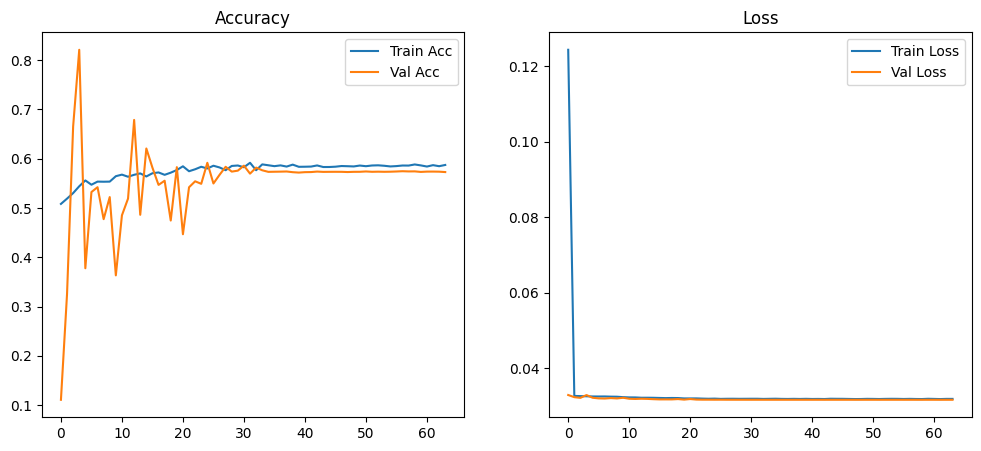

In [80]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=256,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
    class_weight=class_weights
)


# Evaluate
results = model.evaluate(X_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()

637/637 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step

F1 Score: 0.2763

Classification Report:
              precision    recall  f1-score   support

           0     0.9217    0.7274    0.8131     18083
           1     0.1897    0.5081    0.2763      2271

    accuracy                         0.7030     20354
   macro avg     0.5557    0.6178    0.5447     20354
weighted avg     0.8401    0.7030    0.7532     20354

[[13154  4929]
 [ 1117  1154]]


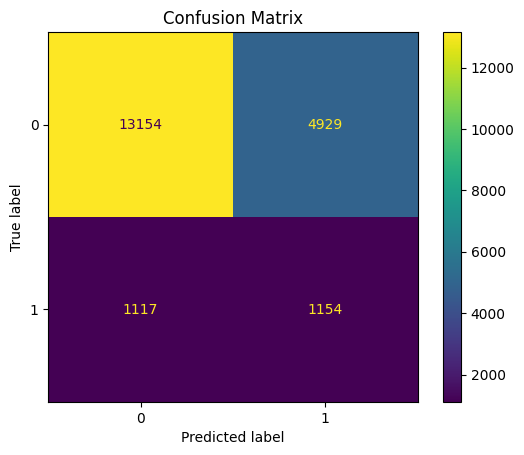

In [84]:
# 🔮 Predict probabilities
y_pred_probs = model.predict(X_test)
# 🧾 Convert probabilities to class labels
y_pred_classes = (y_pred_probs > 0.52).astype(int).flatten()

# 🧠 F1 Score
f1 = f1_score(y_test, y_pred_classes)
print(f"\nF1 Score: {f1:.4f}")

# 📊 Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, digits=4))

cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Confusion Matrix")
plt.show()